In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive

/content/drive/MyDrive


In [3]:
!pip install transformers
!pip install sentencepiece
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 28.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.3 MB

In [4]:
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import os
import json

In [131]:
import os
import json
import re
from zipfile import ZipFile

cond = re.compile('[가-힣]+')

def get_data_from_zip(zip_name):
    zip_file_path = '/content/drive/MyDrive/jolnon/' + zip_name + '.zip'
    extract_path = '/content/' + zip_name

    # zip 파일 압축 해제
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    result = []
    for name in os.listdir(path=extract_path):
        file_path = os.path.join(extract_path, name)
        if os.path.isdir(file_path):
            for name in os.listdir(path=file_path):
                with open(file_path + '/' + name, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    valid = []
                    for d in data['content'].split('\n'):
                        res = []
                        for word in d.split(' '):
                            if cond.match(word) != None:
                                res.append(word)
                        d = ' '.join(res)
                        if d and not d.replace(' ', '').isdecimal():
                            valid.append(d)
                    result.append('\n'.join([data['title']] + valid))
        else:
            with open(extract_path + '/' + name, 'r', encoding='utf-8') as f:
                data = json.load(f)
                valid = []
                for d in data['content'].split('\n'):
                    res = []
                    for word in d.split(' '):
                        if cond.match(word) != None:
                            res.append(word)
                    d = ' '.join(res)
                    if d and not d.replace(' ', '').isdecimal():
                        valid.append(d)
                result.append('\n'.join([data['title']] + valid))
    return result


In [132]:
import random
random.seed(42)
galleries = ['programming','tree']#,'ktwiz','kartriderdrift','skwyverns_new1','ncdinos','samsunglions_new','doosanbears_new1','giants_new2','sh_new','lgtwins_new','tigers_new']
dataset = []
for e in galleries:
  dataset.append([get_data_from_zip(e)])
cocktail = []
for data in dataset:
  for sen in data:
    cocktail+=sen

In [133]:
def remove_words(sentence, word):
    return ' '.join([w for w in sentence.split() if w != word])
stopwords = ['-dc', 'official', 'App', '이미지' ,'순서','저장']#['ㅋㅋ', 'ex', '나는', 'on', '이미지', '순서', '오늘', '일단', 'and', '이야', '그리고', '내일', '그냥', '000', '조금', '살짝', 'ㅇㅇ', 'ㅈㄱㄴ', '있음', '이거', '내가', '칵하하하', '칵하핫', '근데', '지듣노', 'youtube ', '야스중', '우흥', '한다', 'ㅎㅎ', 'ㅠㅠ', '로오오오오오옹', '하고', '아침', '것도', '추천', '혹시', '새낀데', '같다']
for i in range(len(cocktail)):
  for j in range(len(stopwords)):
    cocktail[i] = remove_words(cocktail[i],stopwords[j])

In [134]:
import collections

def remove_top_n_words(data, n):
    words = [word for sentence in data for word in sentence.split(' ')]
    word_count = collections.Counter(words)
    top_n_words = [word for word, _ in word_count.most_common(n)]
    for i in range(len(data)):
        for word in top_n_words:
            if word=='':
                continue
            data[i] = remove_words(data[i], word)
    return data

def remove_empty_sentences(cocktail, real_labels):
  indices = [i for i, sentence in enumerate(cocktail) if sentence.strip() != '']
  cocktail = [cocktail[i] for i in indices]
  real_labels = [real_labels[i] for i in indices]
  return cocktail, real_labels


In [135]:
real_labels = []
for i in range(len(dataset)):
  real_labels += [i] * len(dataset[i][0])
cocktail = remove_top_n_words(cocktail, 0)
cocktail, real_labels = remove_empty_sentences(cocktail, real_labels)

In [136]:
from transformers import AutoModel, AutoTokenizer
from umap import UMAP
# umap_model = UMAP(random_state=42)
# umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', random_state=42)
model = AutoModel.from_pretrained("klue/roberta-large")
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [137]:
class CustomTokenizer:
  def __init__(self, tokenizer):
    self.tokenizer = tokenizer
  # def __call__(self, target):
  #   return self.tokenizer.tokenize(target)
  def __call__(self, target):
    tokens = self.tokenizer.tokenize(target)
    if len(tokens)==0:
      return []
    if isinstance(tokens[0], str):
      indices = [i for i, token in enumerate(tokens) if not token.startswith('##')]
      tokens = [tokens[i] for i in indices]
    elif isinstance(tokens[0][0], str):
      for j in range(len(tokens)):
        indices = [i for i, token in enumerate(tokens[j]) if not token.startswith('##')]
        tokens[j] = [tokens[j][i] for i in indices]
    return tokens

In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer

custom_tokenizer = CustomTokenizer(tokenizer)
# vectorizer = CountVectorizer(tokenizer=custom_tokenizer, max_features=3000)
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=3000)

In [139]:
# from umap import UMAP
# from hdbscan import HDBSCAN

# umap_model = UMAP(n_neighbors=5, n_components=5, metric='cosine', low_memory=False)
# hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True)

In [140]:
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
bertopic_model_embed_token = BERTopic(language='multilingual',
                          nr_topics=100,
                          # ctfidf_model=ctfidf_model,
                          top_n_words=1)
# bertopic_model_embed_token = BERTopic(embedding_model=model,
#                                       # umap_model=umap_model,
#                                       # hdbscan_model=hdbscan_model,
#                                       # vectorizer_model=vectorizer,
#                                       ctfidf_model=ctfidf_model,
#                                       nr_topics=100,
#                                       top_n_words=1,
#                                       calculate_probabilities=False)
topics, _ = bertopic_model_embed_token.fit_transform(cocktail)

In [141]:
topic_info = bertopic_model_embed_token.get_topic_info()
number_of_topics = len(topic_info) - 1
print(f"생성된 주제의 수: {number_of_topics}")
lst = []
for index, row in topic_info.iterrows():
    topic_num = row['Topic']
    if topic_num != -1:
        topic_name = row['Name']
        pure_topic_name = "_".join(topic_name.split("_")[1:])
        lst.append(pure_topic_name)
for i in lst:
  print(i)

생성된 주제의 수: 99
ㅇㅅㅇ
따자고
꽃이
이거
잎이
물을
식물등
대기업
코드
베고니아
벌레가
한국
화분이
흙은
again
개발자
식물
이름이
이름이
물을
나무
에미넴
가격
공간이
식물
토마토
시작합니당
농약
잘라서
되고싶다
유저
지하부
거대적선
혹시
mz
자야지
밥도
무늬가
필기
수학
귀엽다
이거
지듣노
사이코라
고추
얼음
알로카시아
차단
뿌리가
아가튤립
폭발이다
며칠
있습니다
냄새
뿌리
상황
그릇
성장속도
언어
식쇼
무늬
올리브
뿌리
좆소라도
사진
월루루
노트북
딸기
여름이라
섹스
넘이뻐요
알리에서
온실
초대형
떨궈서
투명
사과
데려온
신청해놓고
유튜브
나트륨
흙이
그란디스
강아지
컴퓨터
php
버섯
쑥을
죽은걸까여
인공지능이
블루베리
책샀는데
제라늄
밭에다
플로리다
지식in에
얘기지
뿌리가
구근


In [142]:
table = [[0 for r in range(2)] for t in range(number_of_topics)]

for j in range(number_of_topics):
  for i in range(len(topics)):
    if topics[i]==j:
      table[j][real_labels[i]]+=1
print(table)

[[618, 843], [113, 672], [0, 512], [71, 155], [0, 201], [3, 169], [5, 160], [141, 3], [142, 0], [0, 141], [4, 116], [89, 30], [9, 92], [0, 96], [37, 57], [94, 0], [1, 89], [0, 88], [6, 73], [0, 74], [4, 64], [10, 58], [8, 60], [5, 57], [1, 61], [1, 55], [47, 3], [7, 43], [0, 48], [40, 8], [47, 0], [0, 46], [8, 37], [3, 40], [41, 0], [36, 5], [22, 19], [0, 39], [38, 0], [36, 1], [2, 35], [5, 31], [22, 13], [31, 3], [0, 32], [0, 32], [0, 31], [29, 2], [0, 31], [0, 30], [29, 0], [7, 20], [25, 2], [2, 25], [0, 24], [20, 3], [3, 20], [3, 19], [22, 0], [0, 21], [1, 20], [0, 20], [0, 20], [14, 5], [4, 15], [10, 9], [19, 0], [0, 18], [5, 12], [16, 1], [0, 17], [5, 12], [0, 16], [1, 15], [0, 16], [1, 15], [2, 14], [0, 15], [15, 0], [9, 6], [12, 2], [0, 14], [0, 14], [1, 13], [13, 0], [13, 0], [0, 12], [0, 12], [0, 11], [11, 0], [0, 11], [8, 3], [0, 11], [0, 11], [0, 11], [8, 2], [9, 1], [0, 10], [0, 10]]


In [143]:
### Reducing outliers
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="c-tf-idf", threshold=0.1)
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="distributions")

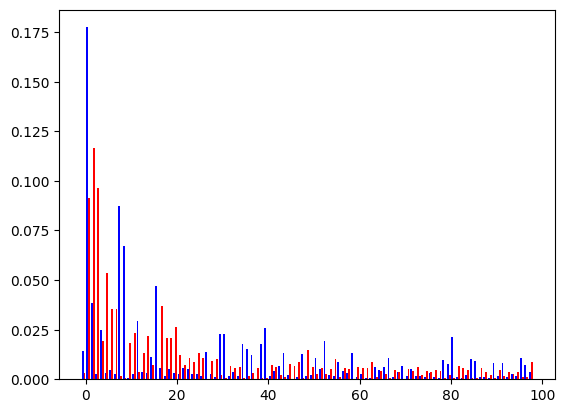

In [144]:
import matplotlib.pyplot as plt

colors = ["#0000FF", "#FF0000"]

data = [[] for _ in range(len(dataset))]
for j in range(len(dataset)):
    data[j] = [topics[i] for i in range(len(real_labels)) if real_labels[i] == j]
    # plt.hist(data[j], bins=number_of_topics, color=colors[j], histtype='bar')
    # plt.show()

plt.hist(data, bins=number_of_topics, color=colors, histtype='bar', density=True)
plt.show()

In [145]:
import numpy as np
npdata = [[] for _ in range(len(dataset))]
for j in range(len(dataset)):
  npdata[j] = np.array([0] * (number_of_topics + 1), dtype=np.float32)
  for k in range(len(data[j])):
    npdata[j][data[j][k] + 1] += 1
  npdata[j] /= npdata[j].sum()

In [146]:
topic_ = [[], []]
threshold = 5
for k in range(number_of_topics):
  ratio = max((npdata[0][k] + 1e-12) / (npdata[1][k] + 1e-12), (npdata[1][k] + 1e-12) / (npdata[0][k] + 1e-12))
  if ratio > threshold:
    if npdata[0][k] > npdata[1][k]:
      topic_[0].append((k - 1, npdata[0][k], npdata[1][k]))
    else:
      topic_[1].append((k - 1, npdata[0][k], npdata[1][k]))

for k in range(len(topic_)):
  topic_[k].sort(key=lambda x: x[k + 1], reverse=True)
  for j, v0, v1 in topic_[k]:
    print('\t'.join([x[0] for x in bertopic_model_embed_token.get_topic(j)]), j, v0, v1, sep='\t')
  print()

대기업	7	0.08716894	0.0018776559
코드	8	0.06711237	0.00079059193
개발자	15	0.0470558	0.00019764798
한국	11	0.029570583	0.0038541357
수학	39	0.025713552	0.000592944
되고싶다	29	0.022627926	0.002371776
유저	30	0.022627926	0.00069176796
나트륨	80	0.021342248	0.00069176796
있습니다	52	0.0195423	0.0024706
mz	34	0.017999485	0.000592944
필기	38	0.01774235	0.00049411994
자야지	35	0.015170995	0.0015811839
시작합니당	26	0.013628182	0.000296472
사이코라	43	0.013113911	0.0010870639
언어	58	0.013113911	0.000296472
차단	47	0.01259964	0.00088941597
노트북	66	0.010542556	0.00088941597
지식in에	95	0.010542556	0.0013835359
컴퓨터	84	0.010028285	0.000592944
신청해놓고	78	0.009514014	0.00049411994
php	85	0.008999743	0.00069176796
상황	55	0.008742607	0.0010870639
인공지능이	89	0.007971201	0.00039529597
얘기지	96	0.0071997945	0.0012847119
섹스	69	0.0066855233	0.000296472
좆소라도	63	0.006428388	0.001185888

꽃이	2	0.0028284907	0.09664987
잎이	4	0.003085626	0.053562604
식물	16	0.0056569814	0.036762524
물을	5	0.004885575	0.035477813
식물등	6	0.002571355	0.035477813
물을	19	0.003085626	0.026287

In [147]:
for k in range(len(npdata)):
  data = sorted([(i - 1, v) for i, v in enumerate(npdata[k].tolist())], key=lambda x: x[1], reverse=True)
  for i in range(10):
    print('\t'.join([x[0] for x in bertopic_model_embed_token.get_topic(data[i][0])]), data[i][0], data[i][1], sep='\t')
  print()

ㅇㅅㅇ	0	0.17742350697517395
대기업	7	0.08716893941164017
코드	8	0.06711237132549286
개발자	15	0.04705579951405525
따자고	1	0.03857032582163811
한국	11	0.029570583254098892
수학	39	0.02571355178952217
이거	3	0.024942144751548767
되고싶다	29	0.022627925500273705
유저	30	0.022627925500273705

따자고	1	0.11680996417999268
꽃이	2	0.09664987027645111
ㅇㅅㅇ	0	0.09160984307527542
잎이	4	0.053562603890895844
식물	16	0.03676252439618111
물을	5	0.035477813333272934
식물등	6	0.035477813333272934
물을	19	0.026287183165550232
벌레가	10	0.023421287536621094
흙은	13	0.022037750110030174



In [148]:
hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail)

100%|██████████| 98/98 [00:01<00:00, 82.30it/s]


In [149]:
# Hierarchical topics
# linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
# hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail, linkage_function=linkage_function)

In [150]:
bertopic_model_embed_token.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [151]:
bertopic_model_embed_token.visualize_heatmap()

In [152]:
tree = bertopic_model_embed_token.get_topic_tree(hierarchical_topics)

In [153]:
print(tree)

.
├─너무
│    ├─개발자
│    │    ├─있습니다
│    │    │    ├─있습니다
│    │    │    │    ├─■──사이코라 ── Topic: 43
│    │    │    │    └─있습니다
│    │    │    │         ├─있습니다
│    │    │    │         │    ├─■──되고싶다 ── Topic: 29
│    │    │    │         │    └─있습니다
│    │    │    │         │         ├─한국
│    │    │    │         │         │    ├─■──대기업 ── Topic: 7
│    │    │    │         │         │    └─■──한국 ── Topic: 11
│    │    │    │         │         └─■──있습니다 ── Topic: 52
│    │    │    │         └─■──인공지능이 ── Topic: 89
│    │    │    └─서버
│    │    │         ├─서버
│    │    │         │    ├─■──유저 ── Topic: 30
│    │    │         │    └─■──코드 ── Topic: 8
│    │    │         └─언어
│    │    │              ├─■──수학 ── Topic: 39
│    │    │              └─■──언어 ── Topic: 58
│    │    └─개발자
│    │         ├─■──개발자 ── Topic: 15
│    │         └─■──필기 ── Topic: 38
│    └─이거
│         ├─이거
│         │    ├─이거
│         │    │    ├─이거
│         │    │    │    ├─올리브
│         │    │    │    │    ├─사진
│   

In [154]:
hierarchical_topics

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
97,196,너무,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",194,너무,195,식물,1.505697
96,195,식물,"[0, 1, 2, 3, 4, 5, 6, 9, 10, 12, 13, 16, 17, 1...",117,이름이,193,너무,1.263535
95,194,너무,"[7, 8, 11, 14, 15, 21, 22, 23, 25, 26, 27, 28,...",185,개발자,192,이거,1.230371
94,193,너무,"[0, 1, 2, 3, 4, 5, 6, 10, 12, 13, 16, 19, 24, ...",189,이거,131,뿌리가,1.183786
93,192,이거,"[14, 21, 22, 23, 25, 26, 27, 28, 32, 33, 34, 3...",186,이거,191,폭발이다,1.150368
...,...,...,...,...,...,...,...,...
4,103,식물,"[6, 16]",6,식물등,16,식물,0.811046
3,102,꽃이,"[1, 2, 4]",4,잎이,100,꽃이,0.770306
2,101,물을,"[5, 19]",19,물을,5,물을,0.744214
1,100,꽃이,"[1, 2]",2,꽃이,1,따자고,0.657529
